In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

import torch
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\willi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


PyTorch Lightning, é um framework leve para treinamento que visa simplificar e acelerar o processo de treinamento.

In [2]:
# Configuração para garantir a reprodutibilidade dos resultados
SEED = 2
# Definem a semente aleatória para as bibliotecas NumPy e PyTorch
np.random.seed(SEED)
torch.manual_seed(SEED) # CPU
torch.cuda.manual_seed(SEED) # GPU
torch.cuda.manual_seed_all(SEED) # GPUs

# Configuração para garantir que a biblioteca cuDNN do PyTorch gere resultados determinísticos (usado para aceleração em GPU)
torch.backends.cudnn.deterministic = True

# Verifica se há uma GPU disponível e define o dispositivo para "cuda" (GPU) ou "cpu" (CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Carrega o Dataset
dataset = pd.read_csv("../../Datasets/dataset_SMOTE100_Scaler.csv")
dataset

,CS_SEXO,NU_IDADE_N,CS_GESTANT,NOSOCOMIAL,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,...,TOMO_RES,RES_AN,VACINA_COV,QTD_DIAS,DIAS_INTERNA,SINT_ATE_NOTIF,PCR_EVOLUCAO,DIAS_DOSE2,DIAS_DOSE1,EVOLUCAO
0,0.995421,-1.242145,-0.718677,-0.291673,-0.699049,-0.561770,-0.427354,-0.039069,-0.201868,-0.085837,...,0.545826,0.553550,-0.409720,-0.444636,-0.568138,-0.344578,-0.197813,-0.029956,-0.756641,0
1,-1.004600,0.443229,0.657872,-0.291673,2.173339,2.492745,-0.968870,2.321590,1.968317,-0.664007,...,0.545826,-1.105958,-0.409720,0.268908,0.656730,-0.344578,-0.477986,-0.006995,-0.053336,0
2,0.995421,-0.399458,-0.718677,-0.291673,-0.124571,-0.561770,-0.968870,-0.629234,-0.744414,-0.085837,...,0.545826,1.106720,-0.409720,-0.360690,-0.496087,-0.303805,-0.477986,-0.025296,-0.402563,0
3,-1.004600,-0.054722,0.657872,-0.291673,-0.699049,-0.561770,-0.427354,-0.629234,-0.744414,-0.664007,...,0.545826,1.659889,0.956430,0.310881,0.728781,0.103916,1.109660,-0.036890,-1.440545,1
4,0.995421,-0.667585,-0.718677,-0.291673,-0.124571,-0.561770,-0.968870,-0.039069,-0.201868,-0.085837,...,-2.106320,0.553550,-0.409720,-0.360690,-0.424036,-0.426122,-0.477986,-0.023704,-0.470469,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27037,0.995421,1.045916,-0.516509,-0.291673,-0.699049,2.492745,1.738710,-0.195859,1.968317,-0.664007,...,0.545826,0.634792,-0.409720,-0.449623,-0.424036,-0.227105,-0.329731,0.006409,0.571365,1
27038,-1.004600,0.750801,0.657872,3.139125,-0.124571,-0.561770,-0.427354,-0.039069,-0.201868,-0.085837,...,-1.897306,1.106720,-0.409720,-0.360690,0.405751,0.516636,0.577774,-0.006064,0.214480,1
27039,0.995421,1.147598,-0.718677,-0.291673,-0.643187,-0.561770,-0.427354,-0.629234,-0.201868,-0.664007,...,0.545826,-0.606578,-0.409720,-0.256336,-0.179858,-0.287947,-0.113503,0.024105,1.328208,1
27040,-1.004600,0.758964,0.657872,-0.291673,-0.124571,-0.413389,-0.427354,-0.182413,-0.333645,-0.226267,...,-2.106320,-1.105958,0.956430,-0.162213,-0.028780,-0.333515,-0.477986,-0.036890,-1.440545,1


Divisão do dataset em três conjuntos distintos: treinamento, validação e teste. Sendo 60% para treinamento, 20% para validação e 20% para teste.


In [4]:
# Cria um array para armazenar os índices do dataset original. Para embaralhar os índices e, posteriormente dividir os dados aleatoriamente.
index = np.array(dataset.index)

# Embaralha os índices de forma aleatória
np.random.shuffle(index)
# Número total de amostras no dataset
n = len(index)

# Seleciona os índices das primeiras 60% amostras embaralhadas para o conjunto de treinamento.
train_index = index[0:int(0.6*n)]
# As amostras da posição 60% até a posição 80% para o conjunto de validação
valid_index = index[int(0.6*n):int(0.8*n)]
# As amostras da posição 80% até o final para o conjunto de teste
test_index = index[int(0.8*n):]

# Cria um dataset para armazenar cada conjunto, treino, validação e teste, respectivamente e reindexa os índices
train_dset = dataset.loc[train_index].reset_index(drop=True)
valid_dset = dataset.loc[valid_index].reset_index(drop=True)
test_dset = dataset.loc[test_index].reset_index(drop=True)

In [5]:
# Obtendo os atributos (features) do dataset, excluindo a coluna 'EVOLUCAO'
input_features = dataset.columns.drop('EVOLUCAO').tolist()

# Obtendo os rótulos (target) do dataset
target = 'EVOLUCAO'
labels = dataset[target].tolist()

In [6]:
# Os dados são convertidos em tensores PyTorch
train_tensor_dset = TensorDataset(
    # converte os dados das colunas de entradas em tensores de ponto flutuante
    torch.tensor(train_dset[input_features].values, dtype=torch.float),
    # converte os dados da coluna de rótulos em tensores de ponto flutuante com formato de matriz
    torch.tensor(train_dset[target].values.reshape(-1,1), dtype=torch.float)
)

valid_tensor_dset = TensorDataset(
    torch.tensor(valid_dset[input_features].values, dtype=torch.float),
    torch.tensor(valid_dset[target].values.reshape(-1,1), dtype=torch.float)
)

test_tensor_dset = TensorDataset(
    torch.tensor(test_dset[input_features].values, dtype=torch.float),
    torch.tensor(test_dset[target].values.reshape(-1,1), dtype=torch.float) 
)

No contexto da biblioteca PyTorch, um tensor é uma estrutura de dados similar a um array NumPy, mas com suporte para aceleração de hardware através de GPUs.

A abordagem com tensores no PyTorch permite representar e manipular os dados de entrada e saída do modelo de forma eficiente, além de oferecer suporte para aceleração de hardware em GPUs, o que é essencial para realizar cálculos complexos em redes neurais profundas com grandes volumes de dados.

In [7]:
class SoftOrdering1DCNN(pl.LightningModule):

    def __init__(self, input_dim, output_dim, sign_size=32, cha_input=16, cha_hidden=32, 
                 K=2, dropout_input=0.2, dropout_hidden=0.2, dropout_output=0.2):
        super().__init__()

        # Calcula o tamanho da camada oculta multiplicando o tamanho do sinal (sign_size) 
        # pela quantidade de canais de entrada (cha_input).
        hidden_size = sign_size*cha_input
        # Armazena o tamanho do sinal
        sign_size1 = sign_size
        # Calcula o tamanho do sinal dividido por 2 e armazena o resultado na variável
        sign_size2 = sign_size//2

        #Calcula o tamanho da camada de saída multiplicando o tamanho do sinal dividido 
        # por 4 pela quantidade de canais ocultos (cha_hidden).
        output_size = (sign_size//4) * cha_hidden

        self.hidden_size = hidden_size # Tamanho do vetor oculto
        self.cha_input = cha_input # Número de canais de entrada
        self.cha_hidden = cha_hidden # Número de canais da camada oculta
        self.K = K # Fator de multiplicação utilizado na primeira camada convolucional
        self.sign_size1 = sign_size1 # Tamanho do sinal de entrada original
        self.sign_size2 = sign_size2 # Tamanho do sinal após a camada de pool adaptativa.
        self.output_size = output_size # Tamanho do vetor de saída após a última camada de convolução e a camada de pool
        self.dropout_input = dropout_input # Taxa de dropout aplicada à camada de entrada
        self.dropout_hidden = dropout_hidden # Taxa de dropout aplicada às camadas ocultas
        self.dropout_output = dropout_output # Taxa de dropout aplicada à camada de saída

        # Cria uma camada de normalização por lote (BatchNorm1d) com tamanho de entrada 
        # igual a input_dim e a atribui ao atributo batch_norm1 da classe.
        self.batch_norm1 = nn.BatchNorm1d(input_dim)
        # Cria uma camada de dropout (Dropout) com taxa de dropout igual a dropout_input 
        # e a atribui ao atributo dropout1 da classe.
        self.dropout1 = nn.Dropout(dropout_input)
        # Cria uma camada densa (Linear) com tamanho de entrada igual a input_dim, tamanho de saída 
        # igual a hidden_size e sem viés (bias=False). A camada é armazenada temporariamente na variável dense1.
        dense1 = nn.Linear(input_dim, hidden_size, bias=False)
        # Aplica a normalização de peso (weight normalization) na camada dense1 e a atribui ao atributo dense1 da classe. 
        self.dense1 = nn.utils.weight_norm(dense1)

        # 1st conv layer
        self.batch_norm_c1 = nn.BatchNorm1d(cha_input)
        conv1 = conv1 = nn.Conv1d(
            cha_input, # canais de entrada
            cha_input*K, # canais de saída
            kernel_size=5, # tamanho de filtro
            stride = 1, # Deslocamento
            padding=2,  # Preenchimento
            groups=cha_input, # igual ao número de canais de entrada e sem viés
            bias=False) #  Essa camada aplica uma convolução em cada canal de entrada separadamente
        # camada convolucional definida anteriormente é normalizada pela norma dos pesos 
        self.conv1 = nn.utils.weight_norm(conv1, dim=None) 

        self.ave_po_c1 = nn.AdaptiveAvgPool1d(output_size = sign_size2)

        # 2nd conv layer
        self.batch_norm_c2 = nn.BatchNorm1d(cha_input*K)
        self.dropout_c2 = nn.Dropout(dropout_hidden)
        conv2 = nn.Conv1d(
            cha_input*K, 
            cha_hidden, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False)
        self.conv2 = nn.utils.weight_norm(conv2, dim=None)

        # 3rd conv layer
        self.batch_norm_c3 = nn.BatchNorm1d(cha_hidden)
        self.dropout_c3 = nn.Dropout(dropout_hidden)
        conv3 = nn.Conv1d(
            cha_hidden, 
            cha_hidden, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False)
        self.conv3 = nn.utils.weight_norm(conv3, dim=None)
        

        # 4th conv layer
        self.batch_norm_c4 = nn.BatchNorm1d(cha_hidden)
        conv4 = nn.Conv1d(
            cha_hidden, 
            cha_hidden, 
            kernel_size=5, 
            stride=1, 
            padding=2, 
            groups=cha_hidden, 
            bias=False)
        self.conv4 = nn.utils.weight_norm(conv4, dim=None)

        # cria uma camada de pooling médio unidimensional
        self.avg_po_c4 = nn.AvgPool1d(kernel_size=4, stride=2, padding=1)

        # cria uma camada de achatamento. É usada para transformar a saída das 
        # camadas convolucionais em um vetor unidimensional
        self.flt = nn.Flatten()

        self.batch_norm2 = nn.BatchNorm1d(output_size)
        self.dropout2 = nn.Dropout(dropout_output)
        dense2 = nn.Linear(output_size, output_dim, bias=False)
        self.dense2 = nn.utils.weight_norm(dense2)

        # Calcula a perda durante o treinamento
        self.loss = nn.BCEWithLogitsLoss()


    # Define a passagem direta (forward pass) do modelo (como os dados fluem pelas camadas)
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = nn.functional.sigmoid(self.dense1(x))

        x = x.reshape(x.shape[0], self.cha_input, self.sign_size1)

        x = self.batch_norm_c1(x)
        x = nn.functional.sigmoid(self.conv1(x))

        x = self.ave_po_c1(x)

        x = self.batch_norm_c2(x)
        x = self.dropout_c2(x)
        x = nn.functional.sigmoid(self.conv2(x))
        x_s = x

        x = self.batch_norm_c3(x)
        x = self.dropout_c3(x)
        x = nn.functional.sigmoid(self.conv3(x))

        x = self.batch_norm_c4(x)
        x = self.conv4(x)
        x =  x + x_s
        x = nn.functional.sigmoid(x)

        x = self.avg_po_c4(x)

        x = self.flt(x)

        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = self.dense2(x)

        return x

    # Métricas
    def roc_auc(self, y_pred, y_true):
        # Calcula o ROC AUC usando sklearn.metrics.roc_auc_score
        roc_auc = roc_auc_score(y_true.cpu(), torch.sigmoid(y_pred).cpu())
        return torch.tensor(roc_auc)

    def accuracy(self, y_pred, y_true):
        # Arredonda as probabilidades previstas para obter as previsões binárias (0 ou 1)
        y_pred_labels = torch.round(torch.sigmoid(y_pred))
        # Calcula a acurácia usando sklearn.metrics.accuracy_score
        acc = accuracy_score(y_true.cpu(), y_pred_labels.cpu())
        return torch.tensor(acc)

    def f1(self, y_pred, y_true):
        # Arredonda as probabilidades previstas para obter as previsões binárias (0 ou 1)
        y_pred_labels = torch.round(torch.sigmoid(y_pred))
        # Calcula o F1-score usando sklearn.metrics.f1_score
        f1score = f1_score(y_true.cpu(), y_pred_labels.cpu())
        return torch.tensor(f1score)
    
    def calculate_confusion_matrix(self, y_pred, y_true):
        # Arredonda as probabilidades previstas para obter as previsões binárias (0 ou 1)
        y_pred_labels = torch.round(torch.sigmoid(y_pred))
        # Calcula a matriz de confusão usando as previsões e os rótulos verdadeiros
        cm = confusion_matrix(y_true.cpu(), y_pred_labels.cpu())
        return cm
    
    def plot_confusion_matrix(self, cm):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()
        

    # define os passos de treinamento do modelo.
    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        loss = self.loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        loss = self.loss(y_hat, y)
        
        # Calcular métricas durante a validação
        valid_auc = self.roc_auc(y_hat, y)
        valid_acc = self.accuracy(y_hat, y)
        valid_f1 = self.f1(y_hat, y)
        
        self.log('valid_loss', loss)
        self.log('valid_auc', valid_auc, prog_bar=True)
        self.log('valid_acc', valid_acc, prog_bar=True)
        self.log('valid_f1', valid_f1, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        X, y = batch
        y_logit = self.forward(X)
        y_probs = torch.sigmoid(y_logit).detach().cpu().numpy()
        loss = self.loss(y_logit, y)

        # Calcular métricas
        roc_auc = self.roc_auc(y_logit, y)
        acc = self.accuracy(y_logit, y)
        f1score = self.f1(y_logit, y)
        cm = self.calculate_confusion_matrix(y_logit, y)
        
        self.plot_confusion_matrix(cm) # Plotar e salvar a matriz de confusão
        self.log('test_loss', loss)
        self.log('test_auc', roc_auc)
        self.log('test_acc', acc, prog_bar=True)
        self.log('test_f1', f1score, prog_bar=True)
        
        
    def configure_optimizers(self):
        # Cria um otimizador SGD
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-2)
        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer, 
                mode="min", 
                factor=0.5, 
                patience=5, 
                min_lr=1e-5),
            'interval': 'epoch',
            'frequency': 1,
            'reduce_on_plateau': True,
            'monitor': 'valid_loss',
        }
        return [optimizer], [scheduler]

In [8]:
model = SoftOrdering1DCNN(
    input_dim=len(input_features), 
    output_dim=1, 
    sign_size=16, 
    cha_input=64, 
    cha_hidden=64, 
    K=2, 
    dropout_input=0.3, 
    dropout_hidden=0.3, 
    dropout_output=0.2
)
print("Número de atributos (input_dim):", len(input_features))

# interromper o treinamento prematuramente se a métrica de validação não melhorar, após x épocas
early_stop_callback = EarlyStopping(
   monitor='valid_loss',
   min_delta=.0,
   patience=21,
   verbose=True,
   mode='min'
)

trainer = pl.Trainer(
    callbacks=[early_stop_callback],
    min_epochs=10, 
    max_epochs=200, 
    accelerator='gpu') # gpus=1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Número de atributos (input_dim): 40


c:\Users\willi\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [9]:
trainer.fit(
    model, 
    DataLoader(train_tensor_dset, batch_size=2048, shuffle=True, num_workers=4),
    DataLoader(valid_tensor_dset, batch_size=2048, shuffle=False, num_workers=4)
)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type              | Params
-----------------------------------------------------
0  | batch_norm1   | BatchNorm1d       | 80    
1  | dropout1      | Dropout           | 0     
2  | dense1        | Linear            | 42.0 K
3  | batch_norm_c1 | BatchNorm1d       | 128   
4  | conv1         | Conv1d            | 641   
5  | ave_po_c1     | AdaptiveAvgPool1d | 0     
6  | batch_norm_c2 | BatchNorm1d       | 256   
7  | dropout_c2    | Dropout           | 0     
8  | conv2         | Conv1d            | 24.6 K
9  | batch_norm_c3 | BatchNorm1d       | 128   
10 | dro

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\willi\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid_loss improved. New best score: 0.696


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.695


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.693


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.687


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.670


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.637


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.601


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.575


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.560


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.552


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.547


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.543


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.542


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.540


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.538


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.537


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.536


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.535


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.534


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.533


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.533


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.532


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.531


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.531


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.530


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.529


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.529


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.528


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.528


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.527


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.527


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.526


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.526


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.526


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.525


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.525


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.525


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.524


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.524


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.524


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.523


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.523


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.523


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.523


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.522


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.522


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.522


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.521


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.521


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.521


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.521


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.520


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.520


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.520


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.520


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.520


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.519


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.519


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.519


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.519


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.518


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.518


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.518


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.518


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.517


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.517


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.517


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.516


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.516


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.516


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.516


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.515


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.515


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.515


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.515


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.515


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.514


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.514


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.514


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.514


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.514


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.513


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.513


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.512


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.512


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.512


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.511


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.511


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.510


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.510


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.510


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.510


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.510


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.509


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.509


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.509


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.508


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.508


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.508


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.507


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.507


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.506


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.506


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.506


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.505


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.505


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.505


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.504


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.504


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.503


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.503


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.502


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.502


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.502


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.501


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.501


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.501


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.500


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.500


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.499


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.499


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.498


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.498


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.498


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.497


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.497


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.496


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.495


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.495


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.494


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.494


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.493


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.493


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.493


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.492


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.492


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.491


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.491


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.490


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.489


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.489


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.488


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.488


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.487


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.487


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.486


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.485


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.485


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.485


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.484


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.483


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.483


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.482


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.482


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.481


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.481


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.480


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.480


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.479


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.479


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.478


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.477


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.476


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.476


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.476


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.475


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.475


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.474


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.474


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.473


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.473


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.472


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.472


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.471


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.471


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.470


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.470


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.469


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.469


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.468


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.468


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.468


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.467


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.466


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.466


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.465


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.465


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.465


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.464


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.464


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.463


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.463


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.462


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.462


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.461


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.461


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.461
`Trainer.fit` stopped: `max_epochs=200` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

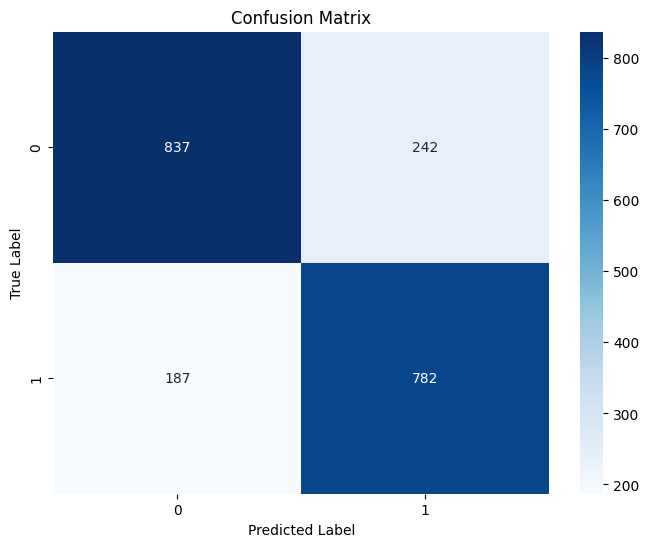

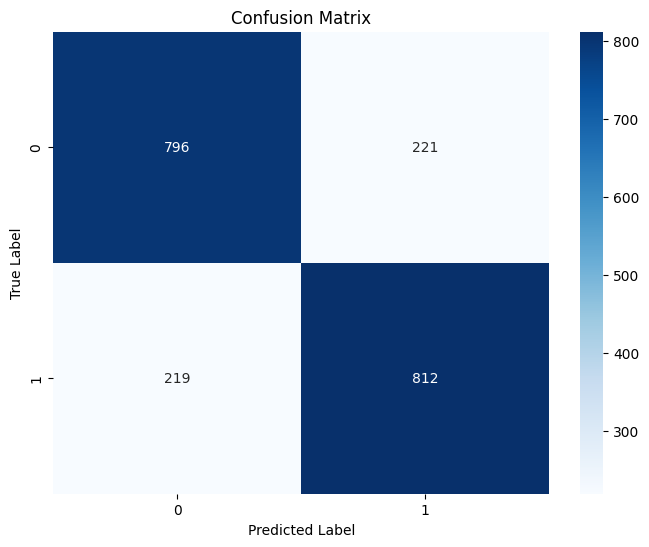

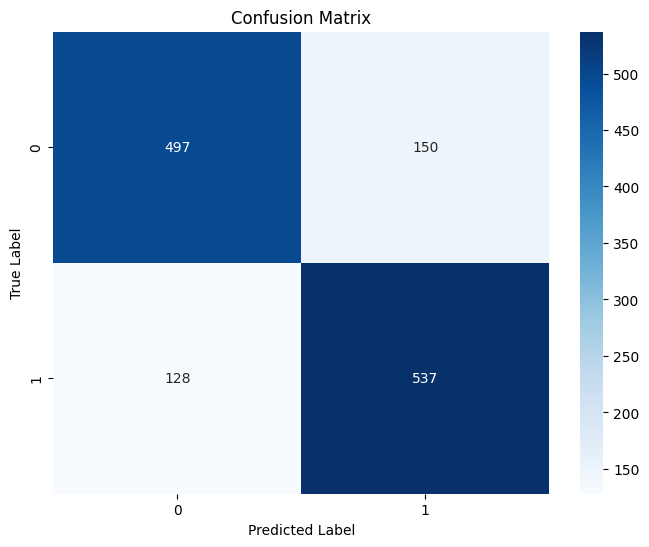

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7879068047337278
        test_auc            0.8694480395279175
         test_f1            0.7878692249458609
        test_loss           0.46066898107528687
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.46066898107528687,
  'test_auc': 0.8694480395279175,
  'test_acc': 0.7879068047337278,
  'test_f1': 0.7878692249458609}]

In [10]:
# Métricas no conjuntos de dados de Validação
trainer.test(model, DataLoader(valid_tensor_dset, batch_size=2048, shuffle=False, num_workers=4))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

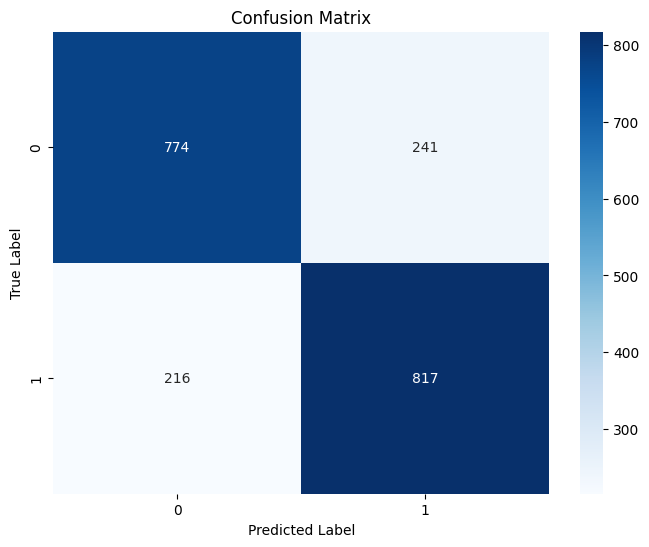

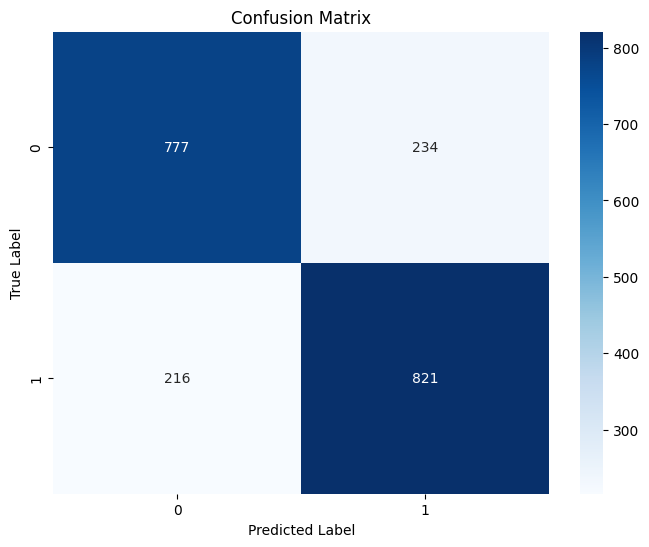

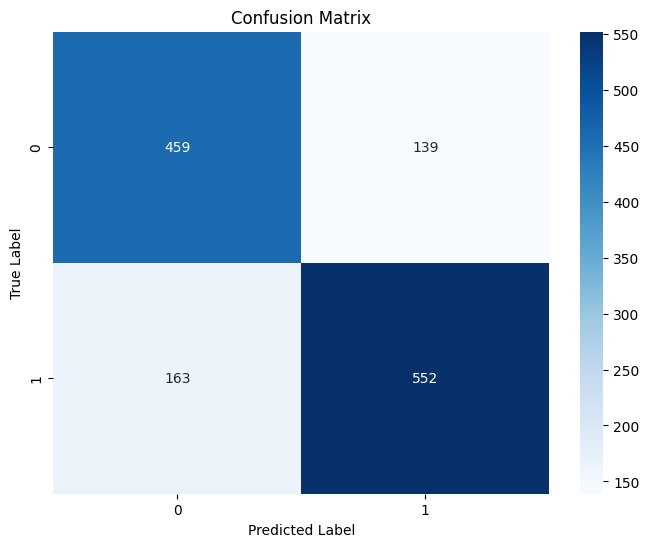

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.776483638380477
        test_auc            0.8616737747874182
         test_f1            0.7836639565202258
        test_loss           0.4694505035877228
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.4694505035877228,
  'test_auc': 0.8616737747874182,
  'test_acc': 0.776483638380477,
  'test_f1': 0.7836639565202258}]

In [11]:
# Métricas no conjuntos de dados de Teste
trainer.test(model, DataLoader(test_tensor_dset, batch_size=2048, shuffle=False, num_workers=4))